In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

### Задание

Руководство компании обратило внимание на то, что сотрудники старше 35 лет болеют чаще, чем более молодые сотрудники. Кроме этого, среди мужчин количество пропусков рабочих дней в связи с больничным выше, чем среди женщин. В связи с этой ситуацией, руководство организации планирует ввести дополнительные медицинские осмотры среди групп риска.

необходимо проверить следующие **гипотезы**:

1) Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин.

2) Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.

## Подготовка данных


In [ ]:
data = pd.read_csv('/content/М.Тех_Данные_к_ТЗ_DS.csv', delimiter=',', encoding='windows-1251', quotechar='"')
data.head()

,"Количество больничных дней,""Возраст"",""Пол"""
0,"5,39,""Ж"""
1,"4,54,""М"""
2,"4,26,""М"""
3,"5,42,""М"""
4,"4,29,""М"""


переделаю в три столбца


In [ ]:
data.columns=[it.replace('"','') for it in data.columns]
data['work_days'] = data['Количество больничных дней,Возраст,Пол'].str.split(',').str[0].astype(int)
data['age'] = data['Количество больничных дней,Возраст,Пол'].str.split(',').str[1].astype(int)
data['gender'] = data['Количество больничных дней,Возраст,Пол'].str.split(',').str[2].str.replace('"','')
data.drop(columns=['Количество больничных дней,Возраст,Пол'], inplace=True)

In [ ]:
data.head()

,work_days,age,gender
0,5,39,Ж
1,4,54,М
2,4,26,М
3,5,42,М
4,4,29,М


Распределения характеристик

## Первая гипотеза
**Мужчины пропускают в течение года более 2 рабочих дней по болезни значимо чаще женщин.**


Для начала посмотрим распределение пропусков по болезни поближе

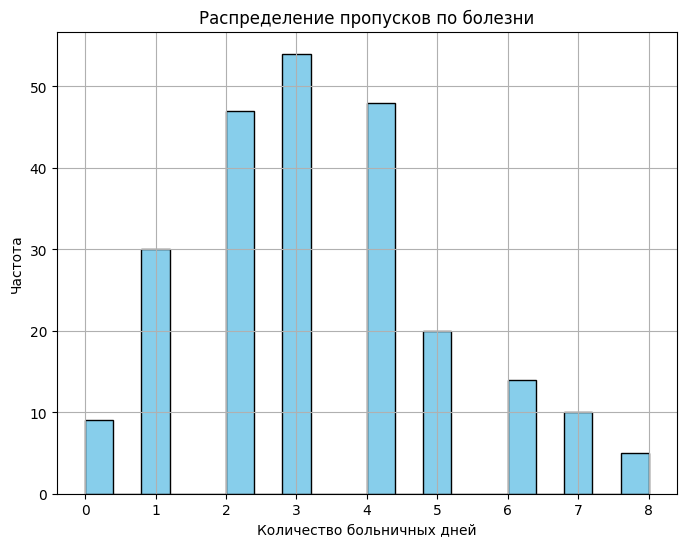

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(data['work_days'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Количество больничных дней')
plt.ylabel('Частота')
plt.title('Распределение пропусков по болезни')
plt.grid(True)
plt.show()

и распределение по полу

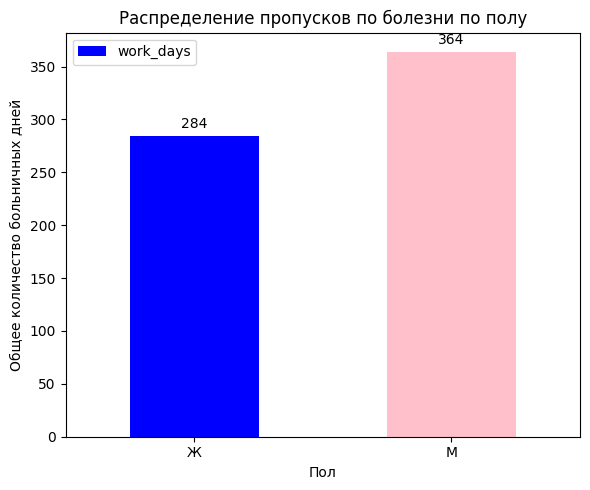

In [ ]:
grouped_data = data[data['work_days']>2].groupby('gender')['work_days'].sum()

plt.figure(figsize=(6, 5))
grouped_data.plot(kind='bar', color=['blue', 'pink'])
plt.title('Распределение пропусков по болезни по полу')
plt.xlabel('Пол')
plt.ylabel('Общее количество больничных дней')
plt.xticks(rotation=0)

for index, value in enumerate(grouped_data):
    plt.text(index, value + 5, f'{value}', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

Т.к. распределение немного скошено влево, лучше использую бутстрап при применении t-test далее


In [ ]:
def bootstrap_ttest(data1, data2, n_iter=1000):
    t_statistic = np.zeros(n_iter)
    for i in range(n_iter):
        combined = np.concatenate((data1, data2))
        np.random.shuffle(combined)
        perm_sample1 = combined[:len(data1)]
        perm_sample2 = combined[len(data1):]
        t_statistic[i] = abs(ttest_ind(perm_sample1, perm_sample2, equal_var=False).statistic)
    return t_statistic

Теперь сделаем статистическую проверку

Подготовлю данные для первой гипотезы

In [ ]:
q1 = data[data['work_days'] > 2]
male_data = q1[q1['gender'] == 'М']
female_data = q1[q1['gender'] == 'Ж']

In [ ]:
boot_t_statistic = bootstrap_ttest(male_data.work_days, female_data.work_days)
p_value = (np.sum(boot_t_statistic > abs(ttest_ind(male_data.work_days, female_data.work_days, equal_var=False).statistic)) + 1) / (len(boot_t_statistic) + 1)
print(f"p-value: {p_value}\n")
if p_value < 0.05:
    print("Есть статистически значимые различия между группами.")
else:
    print("Нет статистически значимых различий между группами.")

p-value: 0.6353646353646354

Нет статистически значимых различий между группами.


То есть, хотя количество пропущенных рабочих дней могут отличаться между мужчинами и женщинами, эта разница не считается статистически значимой на уровне 0.05.

## Вторая гипотеза
**Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.**

Также сначала подготовлю данные

In [ ]:
q2 = data[data['work_days'] > 2]
# деление данных на две группы
older_than_35 = q2[q2['age'] > 35]['work_days']
k_older_than_35 = older_than_35.sum()
younger_than_35 = q2[q2['age'] <= 35]['work_days']
k_younger_than_35 = younger_than_35.sum()

посмотрю какое распределение

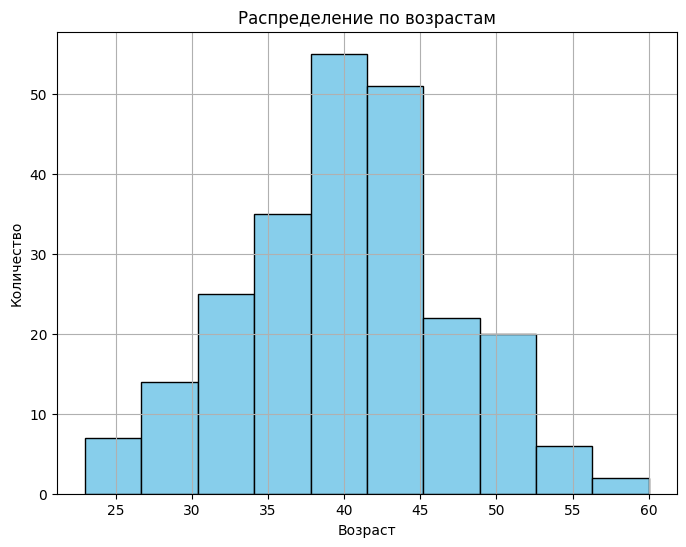

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(data['age'], color='skyblue', edgecolor='black')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение по возрастам')
plt.grid(True)
plt.show()

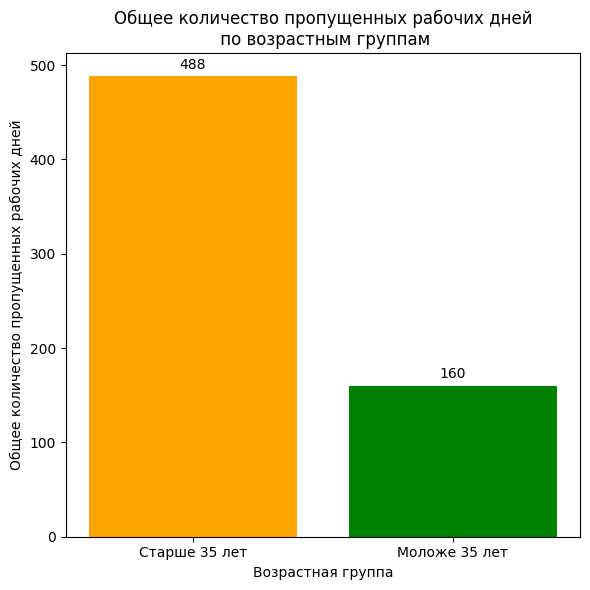

In [ ]:
plt.figure(figsize=(6, 6))
plt.bar(['Старше 35 лет', 'Моложе 35 лет'], [k_older_than_35, k_younger_than_35], color=['orange', 'green'])
plt.title('Общее количество пропущенных рабочих дней\n по возрастным группам')
plt.ylabel('Общее количество пропущенных рабочих дней')
plt.xlabel('Возрастная группа')

plt.text(0, k_older_than_35 + 5, f'{k_older_than_35}', ha='center', va='bottom', color='black')
plt.text(1, k_younger_than_35 + 5, f'{k_younger_than_35}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

распределение близко к нормальному. Использую t-test как есть

In [ ]:
t_stat, p_value = ttest_ind(older_than_35, younger_than_35)
print(f"Значение t-статистики: {t_stat}")
print(f"p-value: {p_value}\n")
if p_value < 0.05:
    print("Есть статистически значимые различия между группами.")
else:
    print("Нет статистически значимых различий между группами.")

Значение t-статистики: -0.7594348478395395
p-value: 0.4487922957971878

Нет статистически значимых различий между группами.


разница не считается статистически значимой на уровне 0.05, поэтому не можем сказать, что работники старше 35 лет более чаще болеют, чем молодые коллеги